In [ ]:
# Check that imports for the rest of the file work.
import tensorflow.compat.v1 as tf
!pip install tensorflow-gan
import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
# Allow matplotlib images to render immediately.
%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)  # Disable noisy outputs.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 5.1 MB/s eta 0:00:00


In [ ]:
# link & mount to google drive to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libs
import pandas as pd
import tensorflow as tf

In [ ]:
# import pre-processed data from google drive and store in dataframe using pandas function
# split the dataset into 6 different datasets, one for each class
# GAN model will generate samples for one class at a time, therefore dataframe needs to be split by class. Will be joined again after all samples have been generated.
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/35/d_Botnet35.csv')
dff_y = df[['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet']]
dff = df.drop(['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet'], axis=1)

In [ ]:
print(dff.shape)

column_names = ['FlowDuration', 'BwdPacketLengthStd', 'PacketLengthVariance', 'DstPort',
       'TotalLengthofFwdPacket', 'PacketLengthStd', 'FlowIATMax',
       'FlowPackets/s', 'FwdPacketLengthMax', 'BwdPacketLengthMax',
       'BwdSegmentSizeAvg', 'RSTFlagCount', 'BwdPacketLengthMean',
       'SubflowFwdBytes', 'PacketLengthMean', 'PacketLengthMax',
       'FwdPackets/s', 'AveragePacketSize', 'FwdSegmentSizeAvg',
       'FwdPacketLengthMean', 'FlowBytes/s', 'SubflowBwdBytes',
       'BwdBulkRateAvg', 'FwdPacketLengthStd', 'TotalLengthofBwdPacket',
       'FwdHeaderLength', 'FlowIATMean', 'BwdHeaderLength', 'FwdRSTFlags',
       'FWDInitWinBytes', 'BwdInitWinBytes', 'FwdIATMax', 'BwdPackets/s',
       'ACKFlagCount', 'FwdSegSizeMin']

(736, 35)


#### Conversione df in array di immagini 2D Gray-scale

Shape of the images array: (736, 1, 35)
Shape of the tabular dataframe: (736, 35)


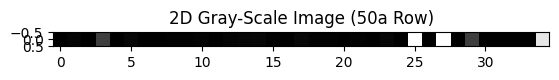

In [ ]:

# Assuming your data is stored in a Pandas DataFrame
# Adjust 'column_names' to the actual names of your 35 important features
your_dataframe = dff

# Initialize a list to store reshaped images
images_list = []

# Iterate through all rows in the DataFrame
for index, row in your_dataframe.iterrows():
    # Extract the row data
    row_data = row[column_names].values

    # Reshape the 1D data into a 2D grid
    image_size = (1, len(column_names))
    grid = np.reshape(row_data, image_size)

    # Create a 2D gray-scale image
    image = np.array(grid * 255, dtype=np.uint8)  # Assuming already in [0, 1] range

    # Append the image to the list
    images_list.append(image)

# Stack the images to create a 3D array
images_array = np.stack(images_list, axis=0)

# Print the shape of the resulting array
print("Shape of the images array:", images_array.shape)
print("Shape of the tabular dataframe:", dff.shape)

print("====================================================")

plt.imshow(images_array[50], cmap='gray', interpolation='nearest')
plt.title('2D Gray-Scale Image (50a Row)')
plt.show()


### WGAN


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the Generator
def build_generator(input_dim, output_dim):
    model = tf.keras.Sequential([
        layers.Dense(128, input_dim=input_dim, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(output_dim, activation='sigmoid')
    ])
    return model

# Define the Discriminator
def build_discriminator(input_dim):
    model = tf.keras.Sequential([
        layers.Dense(256, input_dim=input_dim, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Example dimensions
noise_dim = 100  # Size of the random noise vector
image_dim = 309 * 309  # Size of the flattened 2D gray-scale image

# Build the generator and discriminator
generator = build_generator(noise_dim, image_dim)
discriminator = build_discriminator(image_dim)

# Set different learning rates
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

# Compile the generator with its optimizer
generator.compile(optimizer=generator_optimizer)

# Compile the discriminator with its optimizer
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Print the model summaries
print("Generator Summary:")
generator.summary()

print("\nDiscriminator Summary:")
discriminator.summary()


Generator Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 95481)             24538617  
                                                                 
Total params: 24584569 (93.78 MB)
Trainable params: 24584569 (93.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Discriminator Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               24443392  
               

In [ ]:
epochs = 10 #@param

In [ ]:
# Define GAN model using TF-GAN
gan_model = tfgan.gan_model(
    generator,
    discriminator,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss
)

# Prepare your dataset (images_array assumed to be your dataset)
dataset = tf.data.Dataset.from_tensor_slices(images_array).shuffle(buffer_size=10000).batch(batch_size=64)

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Compile GAN model


# Compile GAN model with different learning rates
gan_model.compile(
    optimizer=[generator_optimizer, discriminator_optimizer],
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the GAN model
gan_model.fit(dataset, epochs=epochs)


### Evaluate and visualize results

In [ ]:
# Generate synthetic samples
num_samples = 10
noise = np.random.normal(0, 1, size=(num_samples, noise_dim))
generated_images = generator.predict(noise)

# Visualize the generated images
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
axs = axs.flatten()

for i in range(num_samples):
    axs[i].imshow(generated_images[i].reshape(309, 309), cmap='gray')
    axs[i].axis('off')

plt.show()